<a href="https://colab.research.google.com/github/kristinazk/HomeworkWeek19/blob/main/nlp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Large scale text analysis with deep learning

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

### About the challenge
For starters, let's download and unpack the data from [here](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=0).

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
!curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17    0    17    0     0     11      0 --:--:--  0:00:01 --:--:--    11
100   299  100   299    0     0    166      0  0:00:01  0:00:01 --:--:--   166
100  119M  100  119M    0     0  16.6M      0  0:00:07  0:00:07 --:--:-- 27.4M
Train_rev1.csv


(244768, 12)

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

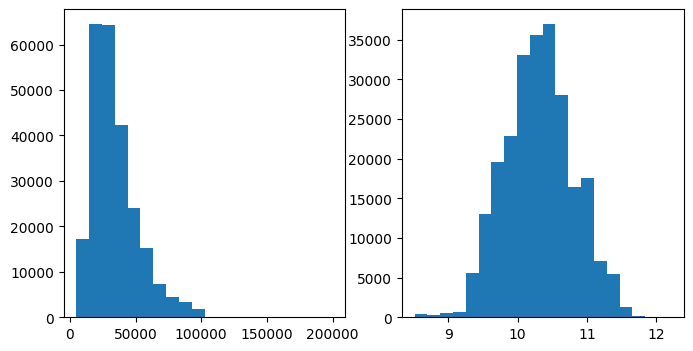

In [3]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [4]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
97749,69270132,Company Commercial Locum Solicitor Bristol,We are seeking a Company Commercial Solicitor ...,Bristol,Bristol,full_time,contract,Austen Lloyd,Legal Jobs,50000 - 60000 per annum + Negotiable,55000,ijobs,10.915107
135474,70286599,Sales Manager Logistics ****K OTE uncapped,Sales Manager Logistics 50K OTE uncapped Job ...,London South East,South East London,NaN,NaN,H2 Recruit,Sales Jobs,"26000 - 32000 per annum + 50k OTE uncap + car,...",29000,salestarget.co.uk,10.275085
46729,68568241,Senior Staff Nurse Radiology Central London,Our client is a leading provider of independen...,City of London - London,The City,full_time,permanent,London4Jobs,Healthcare & Nursing Jobs,32000-33000,32500,london4jobs.co.uk,10.389026


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [5]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [6]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

desc_tokenized = [' '.join(tokenizer.tokenize(str(text).lower())) for text in data['FullDescription']]
title_tokenized = [' '.join(tokenizer.tokenize(str(title).lower())) for title in data['Title']]

for i in range(len(data["Title"])):
  data["Title"][i] = ' '.join(tokenizer.tokenize(str(data["Title"][i]).lower()))
  data["FullDescription"][i] = ' '.join(tokenizer.tokenize(str(data["FullDescription"][i]).lower()))


<ipython-input-6-4e4aee2de323>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Title"][i] = ' '.join(tokenizer.tokenize(str(data["Title"][i]).lower()))
<ipython-input-6-4e4aee2de323>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["FullDescription"][i] = ' '.join(tokenizer.tokenize(str(data["FullDescription"][i]).lower()))


In [7]:
desc_tokenized[:5]

['engineering systems analyst dorking surrey salary **** k our client is located in dorking , surrey and are looking for engineering systems analyst our client provides specialist software development keywords mathematical modelling , risk analysis , system modelling , optimisation , miser , pioneeer engineering systems analyst dorking surrey salary **** k',
 'stress engineer glasgow salary **** to **** we re currently looking for talented engineers to join our growing glasgow team at a variety of levels . the roles are ideally suited to high calibre engineering graduates with any level of appropriate experience , so that we can give you the opportunity to use your technical skills to provide high quality input to our aerospace projects , spanning both aerostructures and aeroengines . in return , you can expect good career opportunities and the chance for advancement and personal and professional development , support while you gain chartership and some opportunities to possibly travel

Now we can assume that our text is a space-separated list of tokens:

In [8]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's count how many times each word is present in the data so that we can build a "white list" of known words.

In [9]:
total_data = desc_tokenized + title_tokenized

# Count how many times does each token occur in both "Title" and "FullDescription" in total
# build a dictionary { token -> its count }

total_data_str = ' '.join(total_data)

token_counts = Counter(total_data_str.split())

# hint: you may or may not want to use collections.Counter
# print(token_counts)

In [10]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('improvemen', 1)
('techniciancivil', 1)
('mlnlycke', 1)
Correct!


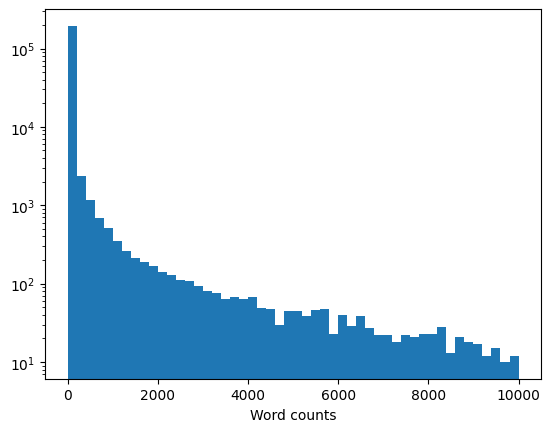

In [11]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Now filter tokens a list of all tokens that occur at least 10 times.

In [12]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = {}

for key, item in token_counts.items():
  if item >= min_count:
    tokens[key] = item


In [13]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


In [14]:
print(tokens)

['UNK', 'PAD', '"', '$', '$****', '$****$****', '$****;', '%', '%)', '%),', '%).', '%****', '%,', '%.', '%/', '%;', '&', '&****', '&/', "'", "'&", "''", "')", "').", "'****", "'****'", "',", "'.", "';", "'>", "'>****", "'>•", "'?", '(', '($****', '(%', '(&', "('", '((', '()', '().', '(****', '(****%)', '(****)', '(****)(', '(****)****', '(****),', '(****).', '(********', '(********)', '(****/', '(****/****', '(****/****)', '(****/****),', '(****/****/****)', '(****:', '(****:****', '(****:****)', '(****:****:****)', '(.', '(>', '(>****', '(?)', '(‘', '(“', ')', ')&', ")'", ')(', '))', ')).', ')****', '),', ').', ').•', ')/', '):', ');', ')>', ')?', ')–', ')•', '****', '****%', '****%)', '****%,', '****%.', '****&', '****&****', "****'", "****'****", "****'********'****", "****',", "****'>", '****(', '****(****', '****(****)', '****(****)(', '****(****)****', '****)', '****)****', '****),', '****).', '****):', '*******', '********', '********%', '********)', '************', '********,',

Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [15]:
idx_arr = range(len(tokens))

for item in tokens:
  if isinstance(item, float):
    print('float!')


token_to_id = {str(key): idx for key, idx in zip(tokens, idx_arr)}

In [16]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

 Task Number C 🚨🚨🚨🚨🚨

In [17]:
from gensim.models import Word2Vec

In [18]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.float32(PAD_IX))

    model = Word2Vec(sequences, vector_size=np.int32(PAD_IX), window=5, min_count=1, sg=0)

    word_vectors = model.wv

    for i,seq in enumerate(sequences):
        row_ix = [word_vectors[word][0] for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [19]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[-0.37633717 -0.5015428   0.8972988   1.          1.        ]
 [ 0.64588726 -0.7116809   1.          1.          1.        ]
 [-0.930295    0.9009273   0.51033497  0.02364314 -0.05362272]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you use more advanced encodings: tf-idf, pretrained w2v etc.

In [20]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [21]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [22]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [23]:
make_batch(data_train[:3], max_len=10)

{'Title': array([[ 0.28765798,  0.51033497,  0.9009273 ,  1.        ,  1.        ,
          1.        ,  1.        ],
        [-0.930295  , -0.7116809 ,  0.64588726,  0.8972988 ,  0.02364314,
         -0.5015428 ,  0.73805046],
        [-0.1533731 , -0.45369732,  0.65540516, -0.48601604, -0.18160176,
         -0.3763579 , -0.05362272]], dtype=float32),
 'FullDescription': array([[ 0.0285336 ,  0.8404507 , -0.39185187,  0.35564616, -0.8412368 ,
          0.0285336 ,  0.8404507 , -0.39185187, -0.405901  ,  0.35564616],
        [-0.13959196,  0.7985322 ,  0.0571868 ,  0.16661906,  0.9854162 ,
         -0.38370726,  0.61081547,  0.626581  , -0.40732074,  0.32043806],
        [ 0.56921834,  0.86669147,  0.6154691 ,  0.7355028 , -0.405901  ,
         -0.7403211 ,  0.34139472, -0.8412368 ,  0.5450827 ,  0.949469  ]],
       dtype=float32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use __[Keras Functional API](https://keras.io/models/model/)__.

In [24]:
import tensorflow as tf
import keras
import keras.layers as L

## Final task: improve over it

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a full grade. Write a short report about what you have tried. More ideas = more bonus points.

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know this stuff.

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout.
* Batch Norm.
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time - our `L.GlobalMaxPool1D`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/).

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not want to use __`.get_keras_embedding()`__ method for word2vec
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback](https://keras.io/api/callbacks/early_stopping/).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck!

In [25]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """


    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")

    model_title = L.LSTM(10)(tf.expand_dims(l_title,axis=-1))
    model_descr = L.LSTM(10)(tf.expand_dims(l_descr,axis=-1))
    concat_input = tf.concat([model_title, model_descr, l_categ], axis=1)

    # conv_layer = L.Conv2D(filters=32, kernel_size=(4, 4), activation='relu')(concat_input)
    # batchnorm_layer = L.BatchNormalization()(conv_layer)
    # dropout = L.Dropout(0.25)(batchnorm_layer)
    # max_pooling = L.GlobalMaxPooling1D(pool_size=2, strides=2)(dropout)
    # conv_layer = L.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(max_pooling)
    # batchnorm_layer = L.BatchNormalization()(conv_layer)
    # dropout = L.Dropout(0.25)(batchnorm_layer)
    # max_pooling = L.GlobalMaxPooling1D(pool_size=2, strides=2)(dropout)
    # dense_l = L.Dense(32, activation='relu')(max_pooling)
    # batchnorm_layer = L.BatchNormalization()(dense_l)
    # dropout = L.Dropout()(batchnorm_layer)
    # dense_l = L.Dense(64, activation='relu')(dropout)
    # batchnorm_layer = L.BatchNormalization()(dense_l)
    # dropout = L.Dropout()(batchnorm_layer)

    # lstm_layer1 = L.Bidirectional(tf.keras.layers.LSTM(units=16))(concat_input)
    # batchnorm = L.BatchNormalization()(lstm_layer1)
    # dropout = L.Dropout(0.25)(batchnorm)
    # lstm_layer2 = L.Bidirectional(tf.keras.layers.LSTM(units=16))(dropout)
    # batchnorm = L.BatchNormalization()(lstm_layer2)
    # dropout = L.Dropout(0.25)(batchnorm)

    model_title = L.Bidirectional(L.LSTM(10))(tf.expand_dims(l_title,axis=-1))
    model_descr = L.Bidirectional(L.LSTM(10))(tf.expand_dims(l_descr,axis=-1))
    concat_input = tf.concat([model_title, model_descr, l_categ], axis=1)
    dense = L.Dense(64, activation='relu')(concat_input)
    batchnorm_layer = L.BatchNormalization()(dense)
    dropout = L.Dropout(0.25)(batchnorm_layer)
    x = L.Dense(128, activation='relu')(dropout)

    output_layer = L.Dense(1)(x)

    # end of your code

    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model


In [26]:
model = build_model()
model.summary()

dummy_pred = model.predict(make_batch(data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(data_train[:100]), data_train['Log1pSalary'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Title (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 FullDescription (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 tf.expand_dims_2 (TFOpLambda)  (None, None, 1)      0           ['Title[0][0]']                  
                                                                                                  
 tf.expand_dims_3 (TFOpLambda)  (None, None, 1)      0           ['FullDescription[0][0]']        
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['Log1pSalary'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


4/4 [==============================] - 2s 70ms/step


/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['Log1pSalary'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


#### Training and evaluation

As usual, we gonna feed our model with random minibatches of data.

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [27]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target

        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [30]:
batch_size = 256
epochs = 100          # definitely too small
steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

model = build_model()

# TASK E
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05),
                    epochs=epochs, steps_per_epoch=steps_per_epoch,

                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size, callbacks=[early_stopping]
                   )

<ipython-input-30-9ab582343ab6>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05),


Epoch 1/100
100/100 [==============================] - 293s 3s/step - loss: 26.2956 - mean_absolute_error: 3.8993 - val_loss: 62.4882 - val_mean_absolute_error: 7.8890
Epoch 2/100
100/100 [==============================] - 329s 3s/step - loss: 1.6822 - mean_absolute_error: 1.0302 - val_loss: 52.7410 - val_mean_absolute_error: 7.2457
Epoch 3/100
100/100 [==============================] - 286s 3s/step - loss: 1.3820 - mean_absolute_error: 0.9359 - val_loss: 37.4211 - val_mean_absolute_error: 6.0991
Epoch 4/100
100/100 [==============================] - 330s 3s/step - loss: 1.3253 - mean_absolute_error: 0.9151 - val_loss: 20.9502 - val_mean_absolute_error: 4.5562
Epoch 5/100
100/100 [==============================] - 331s 3s/step - loss: 1.0316 - mean_absolute_error: 0.8063 - val_loss: 7.9186 - val_mean_absolute_error: 2.7804
Epoch 6/100
100/100 [==============================] - 330s 3s/step - loss: 0.9321 - mean_absolute_error: 0.7707 - val_loss: 2.6060 - val_mean_absolute_error: 1.5541

In [31]:
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error

print_metrics(model, data_train, name='Train')
print_metrics(model, data_val, name='Val');

8/8 [==============================] - 3s 94ms/step
Train results:
Mean square error: 0.24242
Mean absolute error: 0.38754
2/2 [==============================] - 0s 88ms/step
Val results:
Mean square error: 0.24941
Mean absolute error: 0.39354


### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [ ]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens))

    *predictions_drop_one_token, baseline_pred = model.predict(make_batch(data_drop_one_token))[:, 0]
    diffs = baseline_pred - predictions_drop_one_token
    return list(zip(sample_col_tokens, diffs))

In [33]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):

    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]


    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html


In [34]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['Log1pSalary'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


sales specialist iv access and infusion

11/11 [==============================] - 0s 35ms/step


sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [35]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['Log1pSalary'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


cleaning operative

3/3 [==============================] - 0s 12ms/step


12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

In [36]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model.predict(make_batch(data.iloc[i: i+1]))[0, 0]))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 88168
1/1 [==============================] - 0s 57ms/step
Salary (gbp): 6257.4375
1/1 [==============================] - 0s 57ms/step


multilingual technical support advisors belfast call centre

12/12 [==============================] - 0s 40ms/step


our client a belfast call centre require technical support advisors these roles are starting mid march 2013 . candidates must already have authorisation to work in the uk . duties responsibilities : • provide technical support to customers with a linksys product ( router , cameras , range UNK , access point , etc ) • help customers to connect third party devices with their linksys product ( tablets , laptops , xbox , wii , smart phones , printers , smart tv , etc ) • responsible for resolving easy to moderate technical problems . • selling warranty extensions for customers with out of warranty devices , also selling support plan and direct connect services for in warranty devices . • helping customers to change defective products ( rma ). • share knowledge with other people , in writing technical documents and enlarging the knowledge database . essential criteria : • fluent in written and spoken english danish , dutch , german , russian or turkish • customer focus 6 months outstanding customer service experience in a service driven environment • specialist expertise basic technical skills and knowledge • strong interest in home / consumer electronics • interest in technology and the willingness to learn . • planning organising ability to multitask , plan and prioritise workload • effective communication excellent communication skills both verbal and written • planning organising flexible , ability to multitask , plan and prioritise workload • working with others demonstrates experience of working in a team based environment supporting the team in achieving the highest quality standards and takes an active role in generating team morale • autonomous worker with team spirit . • eager to learn . • outofthebox thinker . • able to take initiative and drive change . desirable criteria : • knowledge of networking salary **** per annum hours of work 40 hours per week on a rotational shift pattern from monday to friday 9am 7pm however your department ' s operational hours are 24 hours 7 days per week . your operational hours may be subject to change due to operational requirements . the nature of your employment is such that you will work whatever hours may be necessary to fulfill the duties of your post .